# Predict cfr if COVID started at a different time

The goal of this notebook is, to predict what would have happened, if covid had started at a different time (and therefore at a different temperature).

In [1]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "svg")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta
from tqdm import tqdm

import sys
sys.path.append("../src/")
from helpers import ExpSigModel, season_colormap

In [2]:
data = pd.read_csv("../dat/SimpleCombinedData.csv", parse_dates=["date"])
data.head()

,date,cases,deaths,cases_smoothed,deaths_smoothed,cfr,air temperature
0,2020-01-02,1.0,0.0,0.142857,0.0,0.0,2.820693
1,2020-01-03,0.0,0.0,0.142857,0.0,0.0,2.697867
2,2020-01-04,0.0,0.0,0.142857,0.0,0.0,3.165813
3,2020-01-05,0.0,0.0,0.142857,0.0,0.0,3.853173
4,2020-01-06,0.0,0.0,0.000000,0.0,0.0,4.002133


In [3]:
data.describe()

,cases,deaths,cases_smoothed,deaths_smoothed,cfr,air temperature
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,11093.848000,155.086667,11037.519429,155.084762,0.015257,11.034674
std,15933.763919,226.854003,14275.290056,214.155816,0.015875,7.039428
min,0.000000,0.000000,0.000000,0.000000,0.000000,-6.803833
25%,862.000000,6.250000,919.535714,5.857143,0.005288,5.264845
50%,4859.500000,55.000000,6264.785714,57.928571,0.008785,10.511453
75%,14766.500000,218.750000,16915.464286,226.464286,0.018636,17.570600
max,111752.000000,1283.000000,75881.285714,984.714286,0.074199,27.135203


perpare data and train model as in `GeneratePredictionAndHeatmap.ipjnb`

In [4]:
def features(time, temp):
    return np.stack([time, temp], axis=1)

In [5]:
X = features(data.index, data["air temperature"])
y = data.cfr.to_numpy()
peak_of_first_wave = np.argmax(y)

In [6]:
model = ExpSigModel(startvalue=peak_of_first_wave)
model.fit(X, y)

 final_simplex: (array([[ 0.26349449, -0.00549297, -0.15731279, -3.4041077 ],
       [ 0.26349485, -0.00549296, -0.15731217, -3.40404568],
       [ 0.26349318, -0.00549296, -0.15731252, -3.40412113],
       [ 0.26349284, -0.00549296, -0.1573127 , -3.40414778],
       [ 0.26349447, -0.00549297, -0.15731277, -3.40411923]]), array([0.03144304, 0.03144304, 0.03144304, 0.03144304, 0.03144304]))
           fun: 0.03144304281448605
       message: 'Optimization terminated successfully.'
          nfev: 246
           nit: 143
        status: 0
       success: True
             x: array([ 0.26349449, -0.00549297, -0.15731279, -3.4041077 ])


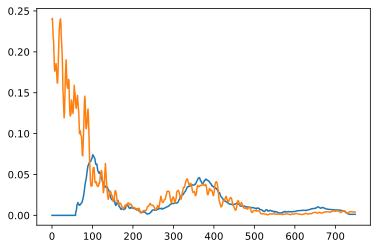

In [7]:
plt.plot(y)
plt.plot(model.predict(X))

# More weather data

Now, that we have the model, we will have to load more weather data to be able to move the starting point:

In [8]:
weather = pd.read_csv("../dat/WeatherData.csv", parse_dates=["date"])
weather = weather.set_index("date").groupby(lambda x: f"{x.year}-{x.month:02d}-{x.day:02d}").mean()
weather.index.names = ["date"]

num_convolve = 5

weather["air temperature"] = np.convolve(
    weather["air temperature"], np.ones(num_convolve), "same"
) / num_convolve

weather.head()

,air temperature
date,
2019-01-01,1.192034
2019-01-02,1.406194
2019-01-03,2.200465
2019-01-04,1.777677
2019-01-05,2.183104


In [9]:
weather.index = pd.to_datetime(weather.index)

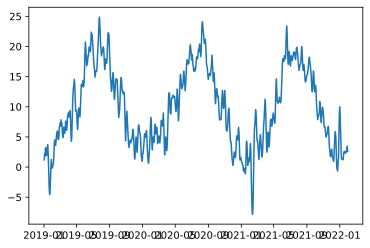

In [10]:
plt.plot(weather["air temperature"])

## Predict

Now that we have the weather data, we can predict for a starting point that is not in spring 2020

In [11]:
actual_startdate = data["date"][0]
print(actual_startdate)
one_year = timedelta(days=365)
print(one_year)

2020-01-02 00:00:00
365 days, 0:00:00


In [12]:
startdates = pd.date_range(actual_startdate-one_year, actual_startdate, freq="1D")
print(startdates[:10])

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-05',
               '2019-01-06', '2019-01-07', '2019-01-08', '2019-01-09',
               '2019-01-10', '2019-01-11'],
              dtype='datetime64[ns]', freq='D')


In [13]:
num_days = data.index.max()
peak_of_wave_offset = timedelta(days=int(peak_of_first_wave))
print(num_days)

749


In [14]:
time = data.index.to_numpy()

In [15]:
predictions = []
for startdate in tqdm(startdates):
    weather_slice = weather[weather.index >= startdate].iloc[:num_days+1]
    temp = weather_slice["air temperature"].to_numpy()[peak_of_first_wave:]
    time = data.index.to_numpy()[peak_of_first_wave:]
    X = features(time, temp)
    y_hat = model.predict(X)
    predictions.append((startdate+peak_of_wave_offset, y_hat))

100%|██████████| 366/366 [00:00<00:00, 1423.32it/s]


In [16]:
SMOOTHING_TIMEFRAME_DAYS = 14

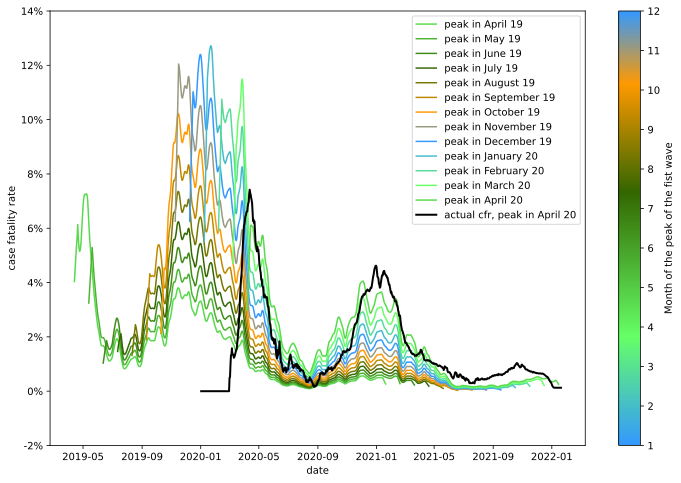

In [39]:
plt.figure(figsize=(12, 8))


for startdate, y_hat in predictions[::30]:
    dates = pd.date_range(startdate, startdate+timedelta(days=len(y_hat)-1), freq="1D")
    y_hat = np.convolve(y_hat, np.ones(SMOOTHING_TIMEFRAME_DAYS), "same") / SMOOTHING_TIMEFRAME_DAYS
    c = season_colormap(startdate.month / 12)
    plt.plot(dates, y_hat, label=f"peak in {startdate.strftime('%B %y')}", color=c)
plt.plot(data["date"], data.cfr, label=f"actual cfr, peak in {data.date.iloc[peak_of_first_wave].strftime('%B %y')}", color="black", linewidth=2)
plt.legend()
plt.colorbar(matplotlib.cm.ScalarMappable(cmap=season_colormap, norm=matplotlib.colors.Normalize(1, 12)), ticks = np.arange(12+1), label="Month of the peak of the fist wave")

plt.xlabel("date")
plt.ylabel("case fatality rate")
y_ticks = plt.yticks()[0]
plt.yticks(y_ticks, [f"{y_tick:2.0%}" for y_tick in y_ticks])

plt.show()

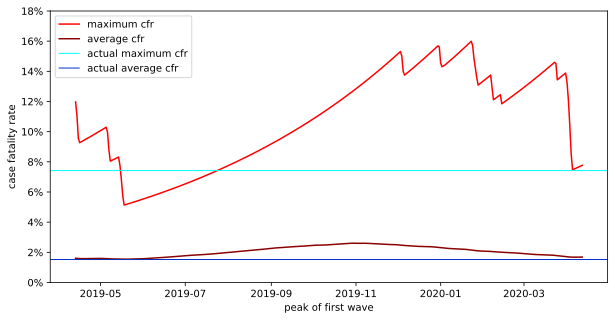

In [40]:
plt.figure(figsize=(10, 5))


dates = list(map(lambda x: x[0], predictions))
maxcfrs = list(map(lambda x: x[1].max(), predictions))
meancfrs = list(map(lambda x: x[1].mean(), predictions))

plt.plot(dates, maxcfrs, color="red", label="maximum cfr")
plt.plot(dates, meancfrs, color="darkred", label="average cfr")

plt.axhline(data.cfr.max(), color="#00ffff", label="actual maximum cfr", linewidth=1)
plt.axhline(data.cfr.mean(), color="#0033cc", label="actual average cfr", linewidth=1)
plt.legend()

plt.xlabel("peak of first wave")
plt.ylabel("case fatality rate")
y_ticks = plt.yticks()[0]
plt.yticks(y_ticks, [f"{y_tick:2.0%}" for y_tick in y_ticks])

plt.show()